# Regression and Other Stories: Simple regression

In [1]:
import arviz as az
from bambi import Model, Prior
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


In [2]:
az.style.use('arviz-grayscale')

### Fitting a regression using a data frame in python

#### Simulate fake data

In [22]:
rng = np.random.default_rng(seed=42)

In [23]:
# R is one indexed
x = np.arange(1, 21)
n = len(x)
a = 0.2
b = 0.3
sigma = 0.5
y = a + b * x + sigma * stats.norm().rvs(n, random_state=rng)


In [24]:
fake = pd.DataFrame({"x": x, "y": y})
fake.head()

,x,y
0,1,0.652359
1,2,0.280008
2,3,1.475226
3,4,1.870282
4,5,0.724482


#### Linear regression model

In [5]:
model = Model("y ~ x", data=fake)
results = model.fit()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, Intercept, x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [6]:
func_dict = {
    "Median": np.median,
    "MAD_SD": stats.median_abs_deviation,
}

coefs = az.summary(results, stat_funcs=func_dict, extend=False, round_to=2)
coefs


,Median,MAD_SD
Intercept,-0.13,0.19
x,0.32,0.02
y_sigma,0.59,0.07


#### Plot for book

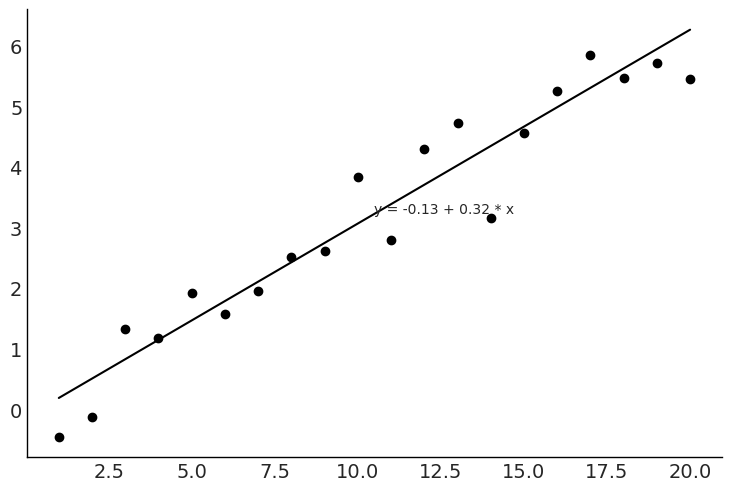

In [7]:
a_hat = coefs.loc["Intercept", "Median"]
b_hat = coefs.loc["x", "Median"]

fig, ax = plt.subplots()
ax.plot(x, a_hat + b_hat * x)
ax.scatter(x, y)

x_bar = x.mean()
ax.text(
    x_bar,
    a_hat + b_hat * x_bar,
    f"y = {np.round(a_hat, 2)} + {np.round(b_hat, 2)} * x",
);


### Formulating comparisons as regression models

#### SImulate fake data

In [8]:
n_0 = 200
y_0 = stats.norm(2, 5).rvs(n_0)
fake_0 = pd.DataFrame(dict(y_0=y_0))
print(y_0.round(1))

[ 5.6  3.7 -1.8  2.3  6.8  0.2 -6.8  0.8  2.3  2.1  0.9  0.6 -0.9  1.1
 -8.  -5.3 -0.1 -6.9  5.6  5.4 -4.1 -2.3  6.9  0.5 -3.3 -1.2 -3.5  5.
  8.7  5.4  0.8  6.5  4.6  5.7  0.3  0.6  3.9 -1.9  8.4  3.7  7.  -4.4
 -5.2  4.1 -2.6  0.2  1.9  0.7 12.4  1.6  3.1  0.  -2.8  0.6  1.   8.3
  3.5 -1.4  1.4 -0.2  0.4 -2.5 -6.6 -1.6  3.3  0.1  6.1  4.6  4.8 -5.9
 -4.   3.6  6.5 10.6  5.4 -0.3 10.5  3.3  7.7  6.5 -2.3  8.  -1.7  3.6
  8.2  4.4 -1.2 11.6 -4.  -9.3  2.   4.   0.7 11.6  1.6  5.   5.8  1.6
 -1.   0.5 -3.4  5.2  0.8 -0.2  6.7  9.6 -3.3 -1.   5.  -7.1  4.9  1.9
 -9.4  2.9 -1.8  3.3  8.1  1.  14.4  6.1  5.   5.6  6.9  0.3  4.   6.
 -0.9 -2.2 -2.1 10.5  5.8 -0.8  3.4 -2.1 -5.6  7.6  6.7  1.7  5.2 -0.3
  5.6  0.4  1.7  5.9  6.3 -1.9  7.  -1.2 13.9  2.4 -4.7  1.3 -2.7 -2.
  3.6 -0.1  0.9  0.9  2.1  6.8 -1.5 -1.6 -3.3 -2.3  0.2 -2.8  2.9 -0.5
  5.9  0.4 10.8 -4.   2.7  3.5  3.5 -3.3  8.9 -2.   5.2  9.4  8.4  4.1
  2.9  4.3 10.   2.4  1.2  0.6 -2.3  7.6  5.   7.8 -5.9  1.   5.3  2.8
  1.2 -2.

In [9]:
np.round(y_0.mean(), 2)


2.1

In [10]:
np.round(y_0.std() / np.sqrt(n_0), 2)


0.32

#### Estimating the mean is the same as regressing on a constant term

In [11]:
priors = {"y_0_sigma": Prior("Flat"), "Intercept": Prior("Flat")}

model = Model("y_0 ~ 1", fake_0, priors=priors)
results = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_0_sigma, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


In [12]:
func_dict = {
    "Median": np.median,
    "MAD_SD": stats.median_abs_deviation,
}

coefs = az.summary(results, stat_funcs=func_dict, extend=False)
coefs


,Median,MAD_SD
Intercept,2.100,0.217
y_0_sigma,4.586,0.155


In [13]:
n_1 = 300
y_1 = stats.norm(8, 5).rvs(n_1)
diff = y_1.mean() - y_0.mean()
se_0 = y_0.std() / np.sqrt(n_0)
se_1 = y_1.std() / np.sqrt(n_1)
se = np.sqrt(se_0**2 + se_1**2)
print(diff)

6.188478010074283


In [14]:
print(se)

0.4482396246182889


#### Estimating a difference is the same as regressing on an indicator variable

In [15]:
n = n_0 + n_1
y = np.concatenate((y_0, y_1))
x = np.concatenate((np.zeros(n_0), np.ones(n_1)))
fake = pd.DataFrame(dict(y=y, x=x))

In [16]:
priors = {"y_0_sigma": Prior("Flat"), "Intercept": Prior("Flat")}
model = Model("y ~ x", fake)
results = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, Intercept, x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


In [17]:
func_dict = {
    "Median": np.median,
    "MAD_SD": stats.median_abs_deviation,
}

coefs = az.summary(results, stat_funcs=func_dict, extend=False)
coefs


,Median,MAD_SD
Intercept,2.114,0.251
x,6.162,0.325
y_sigma,5.087,0.111


### Plot for the book

In [18]:
a_hat = coefs.loc["Intercept", "Median"]
b_hat = coefs.loc["x", "Median"]
x_bar = x.mean()
y0 = y[x == 0].mean().round(2)
y1 = y[x == 1].mean().round(2)

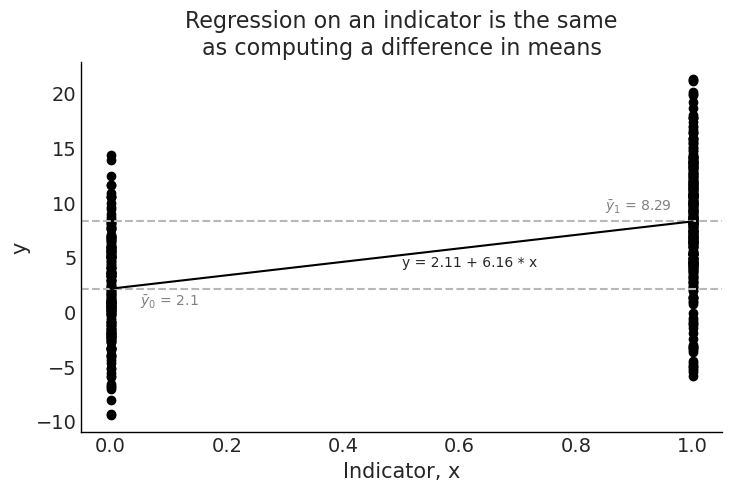

In [19]:
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set(xlabel="Indicator, x", ylabel="y", title="Regression on an indicator is the same\nas computing a difference in means")
ax.axhline(y=y0, color="C3", linestyle='dashed')
ax.axhline(y=y1, color="C3", linestyle='dashed')
ax.plot(x, a_hat + b_hat * x)
ax.text(
    0.5,
    -1 + a_hat + 0.5 * b_hat,
    f"y = {np.round(a_hat, 2)} + {np.round(b_hat, 2)} * x",
)
ax.text(0.05, -1.5 + y[x == 0].mean(), f"$\\bar{{y}}_0$ = {y0}", color="gray")
ax.text(0.85, 1 + y[x == 1].mean(), f"$\\bar{{y}}_1$ = {y1}", color="gray");